# Распознавания алфавита жестов

При помощи компьютерного зрения необходимо распознать американский алфавит жестов.

Обучающий датасет содержит 87 000 изображений жестов размером 200x200 пикселей.

В тестовой выборке всего 28 изображений.

Ссылка на датасет: https://www.kaggle.com/grassknoted/asl-alphabet

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Иморт-библиотек" data-toc-modified-id="Иморт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Иморт библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Оценка-качества-нейросети" data-toc-modified-id="Оценка-качества-нейросети-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Оценка качества нейросети</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

### Иморт библиотек

Импортируем необходимые для решения задачи библиотеки.

In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D

from tensorflow.keras.models import load_model

import numpy as np
from sklearn.metrics import accuracy_score

from IPython.display import display
from ipywidgets import RadioButtons

Для обучения нейросети будет использоваться видеокарта `geforce gtx 1660`. Следующие строчки кода решают неизвестную проблему начала обучения на GPU.

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Загрузка данных

Т.к. изображений очень много, сразу подать их на обучение нейросети не получится. Необходимо разделить выборку на батчи. Сделаем это при помощи датагенератора `ImageDataGenerator` из библиотеки `tf.keras`. Для начала напишем функцию загрузки тренировочной выборки.

In [3]:
def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.2,  # доля изображений для валидации
                                 rescale=1./255,  # нормализация данных
                                 rotation_range=20,  # аугментация - повороты на 20 градусов
                                 width_shift_range=0.05,  # аугментация - смещение по ширине на 20%
                                 height_shift_range=0.05,  # аугментация - смещение по высоте на 20%
                                 zoom_range=0.1)  # аугментация - приближение

    # Загрузим данные из дерикторий
    train_datagen_flow = datagen.flow_from_directory(
        path,
        target_size=(200, 200),
        batch_size=32,  # количество изображений в батче
        class_mode='sparse',  # Класс присваивается по названию папки
        subset='training',  # Тренировочная выборка
        seed=123456)  # сид для повторимости результата (для загрузчика валидации)

    return train_datagen_flow

Загрузчик валидационной выборки будет отличаться отсутствием аугментаций.

In [4]:
def load_validation(path):
    datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

    validation_datagen_flow = datagen.flow_from_directory(
        path,
        target_size=(200, 200),
        batch_size=32,
        class_mode='sparse',
        subset='validation',
        seed=123456,
    )
    return validation_datagen_flow

Загрузчик тестовой выборки отличается отсутствием доли валидации и отсутствием перемешивания сэмплов.

In [5]:
def load_test(path):
    datagen = ImageDataGenerator(rescale=1./255)
    test_datagen_flow = datagen.flow_from_directory(
        path,
        target_size=(200, 200),
        batch_size=32,
        class_mode=None,
        seed=12345,
        shuffle=False
    )

    return test_datagen_flow

Инициилизируем загрузчики.

In [6]:
train = load_train('./asl_alphabet_train/asl_alphabet_train/')
valid = load_validation('./asl_alphabet_train/asl_alphabet_train/')
test = load_test('./asl_alphabet_test/')

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Found 28 images belonging to 1 classes.


Проверим количество классов в датасете.

In [7]:
print('Количество классов в выборке:', len(valid.class_indices))

Количество классов в выборке: 29


Определим фунцию для расшифровки кодирования целевого признака.

In [8]:
def get_key(d, value):
    '''Функция возвращает ключ словаря по его значения.
    d - словарь,
    value - значение ключа'''
    for k, v in d.items():
        if v == value:
            return k

Посмотрим примеры изображений из валидационной выборки.

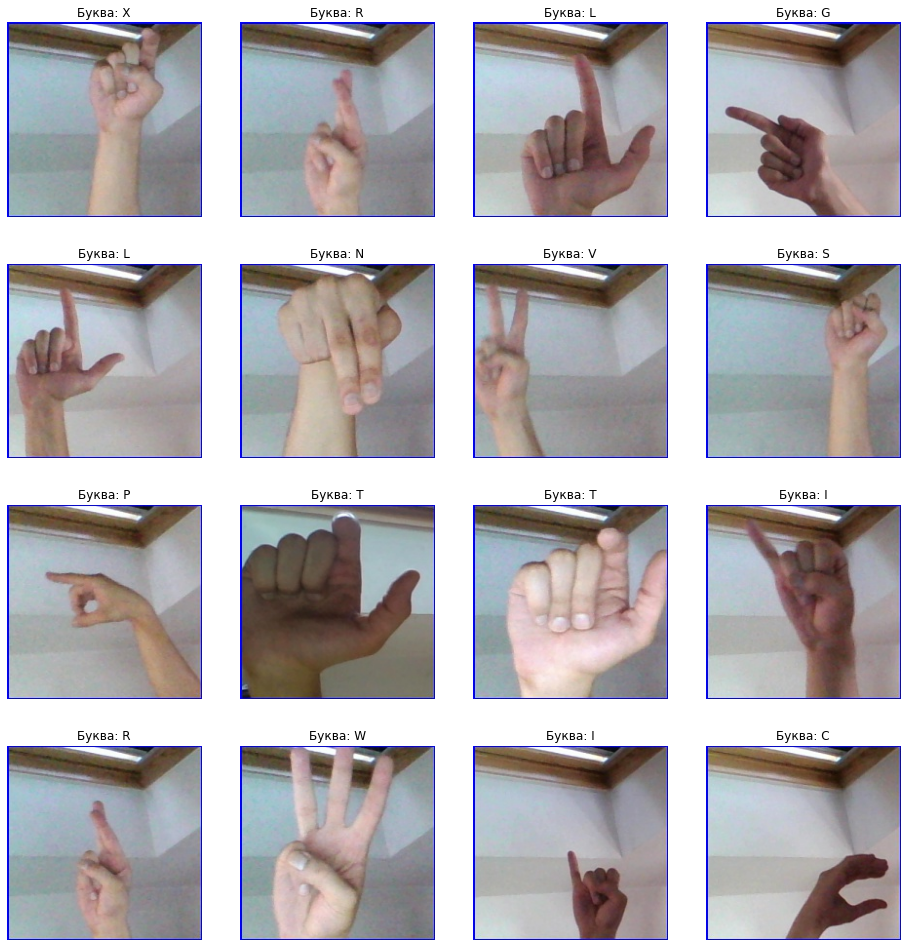

In [9]:
imgs = next(valid)

fig = plt.figure(figsize=(16, 17))

columns = 4
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(imgs[0][i])
    plt.axis('off')
    plt.title(f'Буква: {get_key(valid.class_indices, imgs[1][i])}')
plt.show()

### Обучение модели

Напишем функции для создания и обучения модели. Для нейросети возьмем популярную архитектуру ResNet50. Веса будут инициилизированны случайным образом. Т.к. классов 29, на выходе будет 29 нейронов. Функцию активации для них зададим софтмакс (для интерпритации значений нейронов как вероятность быть этим классом). Лосс-функцией будет категориальная кроссэнтропия. Метрика - доля правильных ответов (accuracy).

In [10]:
def create_model(input_shape=(200, 200, 3)):

    optimizer = Adam(0.01)  # оптимизатор СГД
    backbone = ResNet50(input_shape=input_shape,
                        weights=None,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(29, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer, metrics=['acc'])

    return model


def train_model(model, train_datagen_flow, val_datagen_flow, epochs=1,
                steps_per_epoch=None, validation_steps=None, batch_size=None):

    model.fit(train_datagen_flow,
              validation_data=val_datagen_flow,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=1, shuffle=True, batch_size=batch_size)

    return model

Добавим немного интерактивности: можно выбрать между обучением модели и загрузкой уже обученной

In [11]:
rButtons2 = RadioButtons(
    options=[('Обучение модели', 0), ('Загрузка модели', 1)],
    value=1,  # Выбор по умолчанию
    description='')
CHECK = 1


def on_button_clicked(b):
    CHECK = b['new']


rButtons2.observe(on_button_clicked, names='value')
display(rButtons2)

RadioButtons(index=1, options=(('Обучение модели', 0), ('Загрузка модели', 1)), value=1)

Обучим или загрузим нейросеть. Для обучения будет использовать всего 3 эпохи - это позволит избежать сильного переобучения и должно показать хороший результат на валидационной выборки. Также это положительно скажется на времени обучения (это основная причина малого количества эпох 😊).

In [12]:
if CHECK:
    try:
        model = load_model('m.hdf5')
    except:
        print('Обученная модель не обнаружена, начинаем обучение')
        model = create_model()
        model = train_model(model, train, valid, epochs=3)
else:
    model = create_model()
    model = train_model(model, train, valid, epochs=3)

Обученная модель не обнаружена, начинаем обучение
Epoch 1/3
2175/2175 [==============================] - 871s 398ms/step - loss: 2.8045 - acc: 0.2897 - val_loss: 1.6086 - val_acc: 0.5683
Epoch 2/3
2175/2175 [==============================] - 851s 391ms/step - loss: 0.1528 - acc: 0.9492 - val_loss: 0.4639 - val_acc: 0.8634
Epoch 3/3
2175/2175 [==============================] - 849s 390ms/step - loss: 0.0893 - acc: 0.9713 - val_loss: 0.2752 - val_acc: 0.9234


### Оценка качества нейросети

Сформируем списки расшифрованных предсказаний модели и правильных ответов.

In [13]:
predict = []
for i in np.argmax(model.predict(test.next()), axis=-1):
    predict.append(get_key(train.class_indices, i))
answer = [y.split('_')[0] for y in [x.split('/')[1]
                                    for x in test.filenames]]  # получение правильного ответа

Вычислим accuracy тестовой выборки.

In [14]:
print(
    f'Доля правильных ответов на тестовой выборке: {accuracy_score(answer, predict):.1%}')

Доля правильных ответов на тестовой выборке: 100.0%


При точности 92% на валидационной выборке, нейросеть показала 100% точность на небольшой тестовой.

Посмотрим на тестовую выборку с предсказанием и правильным ответом. (При 100% точности это не имеет особого смысла, но в другом случае было бы довольно полезно.)

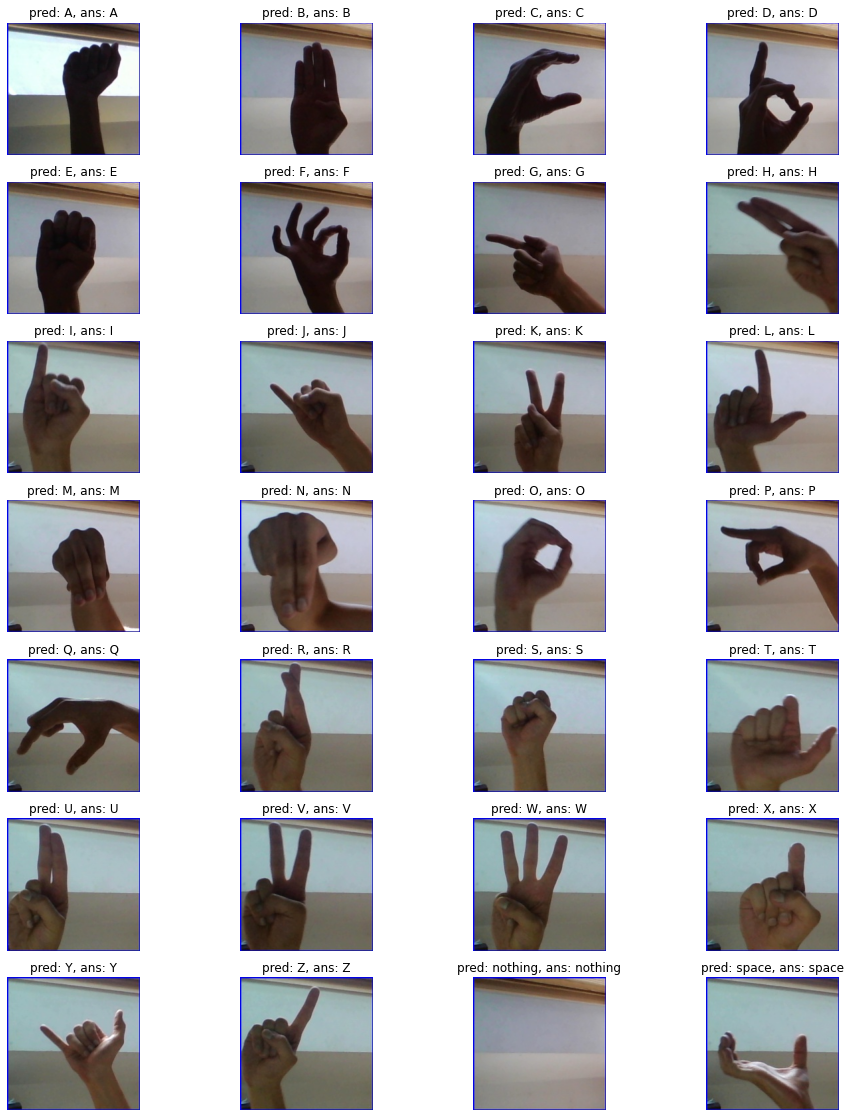

In [15]:
fig = plt.figure(figsize=(16, 20))
columns = 4
rows = 7
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(test[0][i])
    plt.axis('off')
    plt.title(f'pred: {predict[i]}, ans: {answer[i]}')
plt.show()

Сохраним модель

In [18]:
model.save("m.hdf5")

### Вывод
В результате работы была обучена нейросеть для распознавания языка жестов.

Повезло получить 100% результат на тестовой выборке, хотя на валидации качество всего 92%.

Показатель на валидационной выборки можно было бы улучшить проведя больше аугментаций и увеличением количества эпох. Также можно было бы попробовать другие архитектуры нейросети.